## Lets start with loading in the libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import re

In [3]:
def correlation(df, field):
    df_corr = pd.DataFrame(columns=['column', 'correlation', 'p-value'])
    for column in df.columns:
        if column != field:
            correlation, p_value = pearsonr(df[column], df[field])
            if p_value < 0.05:
              df_corr = pd.concat([df_corr, pd.DataFrame([[column, correlation, p_value]], columns=['column', 'correlation', 'p-value'])])
    df_corr
    # plot the correlation

    df_corr = df_corr.sort_values(by=['correlation'], ascending=False)

    plt.bar(df_corr['column'], df_corr['correlation'])
    plt.xticks(rotation=90)
    plt.show()

    return df_corr
        
def read_week_aproach():
    # read the csv file
    df_read = pd.read_csv("data/week_approach.csv")
    
    # get the columns
    columns = df_read.columns
 
    # with .2  means 3 weeks before injury 
    keepColumns = ["injury","Athlete ID", "rel total kms week 0_1", "rel total kms week 0_2", "rel total kms week 1_2", "Date"]
    two_weeks_before_evaluation = list(filter(lambda x: x.endswith(".2") or x in keepColumns, columns)) 
    one_week_before_evaluation = list(filter(lambda x: x.endswith(".1") or x in keepColumns, columns)) 
    week_of_evaluation = list(filter(lambda x: not (x.endswith(".2") or x.endswith(".1")), columns))

    # create a new dataframe with the columns
    df_two_weeks_before_evaluation, df_one_week_before_evaluation, df_week_of_evaluation = df_read[two_weeks_before_evaluation], df_read[one_week_before_evaluation], df_read[week_of_evaluation]

    rename_mapping_for_01 = {col: col.replace('.1', '') for col in df_one_week_before_evaluation.columns}
    rename_mapping_for_02 = {col: col.replace('.2', '') for col in df_two_weeks_before_evaluation.columns}

    # Rename the columns using the mapping
    df_one_week_before_evaluation = df_one_week_before_evaluation.rename(columns=rename_mapping_for_01)
    df_two_weeks_before_evaluation = df_two_weeks_before_evaluation.rename(columns=rename_mapping_for_02)

    # add all rows to one dataframe
    df = pd.concat([df_week_of_evaluation, df_one_week_before_evaluation, df_two_weeks_before_evaluation], ignore_index=True)
    
    return df 

In [4]:
df = read_week_aproach()

In [5]:
# check head of dataframe
df.head()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success,avg recovery,min recovery,max recovery,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.17,0.15,0.18,0,0,0.718447,1.378882,1.919255,0
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.15,0.18,0,0,0.683544,1.018868,1.490566,1
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.15,0.18,0,0,0.683544,1.018868,1.490566,2
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.15,0.18,0,0,0.683544,1.018868,1.490566,3
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.15,0.18,0,0,2.202247,1.361111,0.618056,4


In [6]:
# get dataframe info and show all the info
df.describe()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success,avg recovery,min recovery,max recovery,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
count,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,...,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,128394.000000,1.283940e+05,1.283940e+05,1.283940e+05,128394.000000
mean,5.809446,1.879145,49.202032,13.914409,9.371675,0.923392,1.663138,4.831334,3.431343,4.021045,...,0.525381,0.255245,0.185223,0.343783,34.538249,0.013435,4.408628e+05,9.014685e+05,4.803623e+05,1227.733422
std,2.488364,1.852517,36.836626,9.072183,8.899775,1.039440,1.268528,6.974413,4.559301,5.578139,...,0.390664,0.153218,0.127917,0.219504,19.020678,0.115130,4.328201e+06,6.945449e+06,4.656770e+06,806.488870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.000000,1.000000,22.200000,8.800000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150000,0.110000,0.170000,20.000000,0.000000,6.955224e-01,6.723647e-01,6.923077e-01,437.000000
50%,6.000000,1.000000,44.300000,13.300000,8.000000,1.000000,2.000000,0.000000,0.000000,1.400000,...,0.730000,0.220000,0.160000,0.310000,34.000000,0.000000,9.891862e-01,1.001431e+00,9.897523e-01,1254.000000
75%,7.000000,3.000000,70.000000,18.300000,14.500000,2.000000,3.000000,8.000000,6.300000,6.200000,...,0.840000,0.360000,0.250000,0.520000,50.000000,0.000000,1.320542e+00,1.422222e+00,1.327586e+00,1913.000000
max,14.000000,7.000000,242.000000,135.000000,150.000000,6.000000,7.000000,85.000000,75.000000,80.000000,...,1.000000,0.900000,0.900000,1.000000,73.000000,1.000000,2.096000e+08,2.176000e+08,2.096000e+08,2673.000000


In [7]:
df.dtypes

nr. sessions                                   float64
nr. rest days                                  float64
total kms                                      float64
max km one day                                 float64
total km Z3-Z4-Z5-T1-T2                        float64
nr. tough sessions (effort in Z5, T1 or T2)    float64
nr. days with interval session                 float64
total km Z3-4                                  float64
max km Z3-4 one day                            float64
total km Z5-T1-T2                              float64
max km Z5-T1-T2 one day                        float64
total hours alternative training               float64
nr. strength trainings                         float64
avg exertion                                   float64
min exertion                                   float64
max exertion                                   float64
avg training success                           float64
min training success                           float64
max traini

In [8]:
# check for null values
df.isnull().sum()

nr. sessions                                   0
nr. rest days                                  0
total kms                                      0
max km one day                                 0
total km Z3-Z4-Z5-T1-T2                        0
nr. tough sessions (effort in Z5, T1 or T2)    0
nr. days with interval session                 0
total km Z3-4                                  0
max km Z3-4 one day                            0
total km Z5-T1-T2                              0
max km Z5-T1-T2 one day                        0
total hours alternative training               0
nr. strength trainings                         0
avg exertion                                   0
min exertion                                   0
max exertion                                   0
avg training success                           0
min training success                           0
max training success                           0
avg recovery                                   0
min recovery        

In [9]:
# check for duplicates
df.duplicated().sum()

3338

In [10]:
# check for unique values
df.nunique()

nr. sessions                                      15
nr. rest days                                      8
total kms                                       1807
max km one day                                   409
total km Z3-Z4-Z5-T1-T2                          512
nr. tough sessions (effort in Z5, T1 or T2)        7
nr. days with interval session                     8
total km Z3-4                                    392
max km Z3-4 one day                              187
total km Z5-T1-T2                                326
max km Z5-T1-T2 one day                          144
total hours alternative training                 719
nr. strength trainings                            10
avg exertion                                      96
min exertion                                      92
max exertion                                     101
avg training success                             101
min training success                             101
max training success                          

In [11]:
# check how many injuries we have and how many none injuries

injuries = df[df["injury"] == 1]
no_injuries = df[df["injury"] == 0]

print("Injuries: ", len(injuries))
print("No injuries: ", len(no_injuries))

Injuries:  1725
No injuries:  126669


In [12]:
# get all rows of an athlete

df[df["Athlete ID"] == 1]


,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success,avg recovery,min recovery,max recovery,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
303,10.0,0.0,209.6,42.3,30.6,3.0,3.0,0.0,0.0,30.0,...,0.00,0.16,0.15,0.16,1,0,2.096000e+08,2.096000e+08,0.000000e+00,0
304,11.0,0.0,217.6,42.3,30.6,3.0,3.0,0.0,0.0,30.0,...,0.00,0.16,0.15,0.16,1,0,9.890909e+00,2.176000e+08,2.200000e+07,1
305,10.0,0.0,197.3,37.0,32.3,2.0,3.0,12.0,12.0,20.0,...,0.00,0.16,0.15,0.17,1,0,3.068429e+00,1.973000e+08,6.430000e+07,2
306,10.0,0.0,196.3,36.0,32.3,2.0,3.0,12.0,12.0,20.0,...,0.00,0.16,0.16,0.17,1,0,1.937808e+00,1.963000e+08,1.013000e+08,3
307,11.0,0.0,195.3,36.0,31.3,2.0,3.0,12.0,12.0,19.0,...,0.00,0.16,0.16,0.17,1,0,1.606086e+00,1.953000e+08,1.216000e+08,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86355,10.0,0.0,170.6,34.0,45.1,1.0,3.0,38.1,21.1,7.0,...,0.89,0.21,0.10,0.27,1,0,6.887755e-01,7.913247e-01,1.148886e+00,741
86356,10.0,0.0,165.5,34.0,24.0,1.0,2.0,17.0,17.0,7.0,...,0.83,0.24,0.16,0.33,1,0,7.187500e-01,8.338369e-01,1.160121e+00,742
86357,10.0,0.0,184.0,34.0,36.0,1.0,3.0,29.0,17.0,7.0,...,0.83,0.24,0.16,0.33,1,0,6.548223e-01,7.010870e-01,1.070652e+00,743
127826,6.0,1.0,97.0,22.0,16.0,0.0,2.0,16.0,8.0,0.0,...,0.80,0.35,0.19,0.48,1,1,1.285714e+00,1.206186e+00,9.381443e-01,672


In [13]:
# count the injuries and non-injuries

injuries = df['injury'].values.tolist()
print(injuries.count(1))
print(injuries.count(0))

# make sure the data is balanced

# get the number of rows for each class
injury_count = df['injury'].value_counts()
print(injury_count)

# plot the results

1725
126669
0    126669
1      1725
Name: injury, dtype: int64


In [14]:
# print all unique values of "injury"

df['injury'].unique()

array([0, 1])

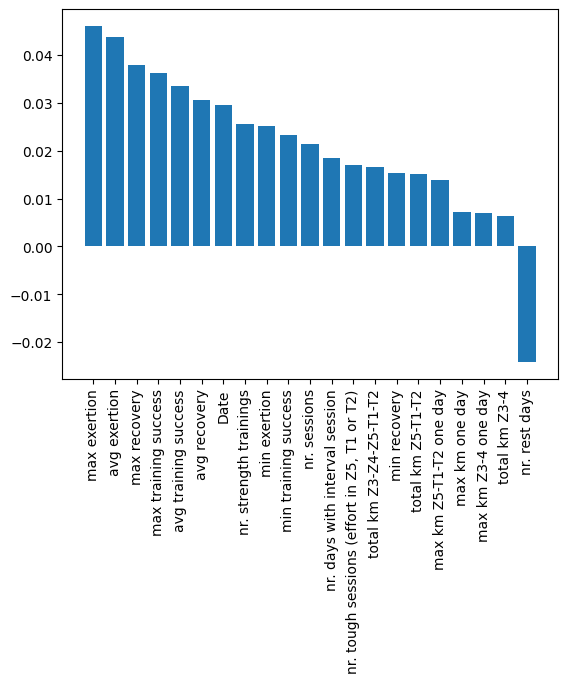

In [15]:
df_corr = correlation(df, "injury")

In [16]:
df_corr

,column,correlation,p-value
0,max exertion,0.046033,0.0
0,avg exertion,0.043693,0.0
0,max recovery,0.037922,0.0
0,max training success,0.036306,0.0
0,avg training success,0.03352,0.0
0,avg recovery,0.030666,0.0
0,Date,0.029498,0.0
0,nr. strength trainings,0.025526,0.0
0,min exertion,0.025179,0.0
0,min training success,0.023304,0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


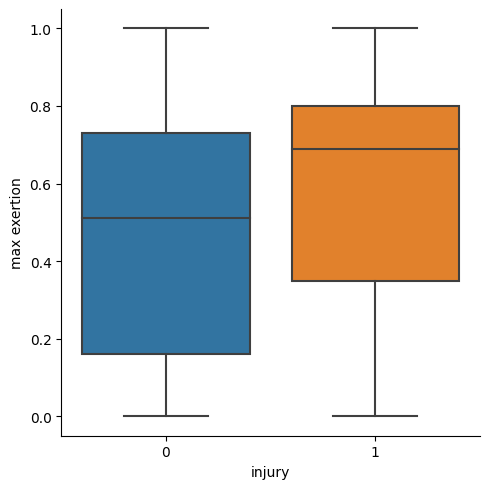

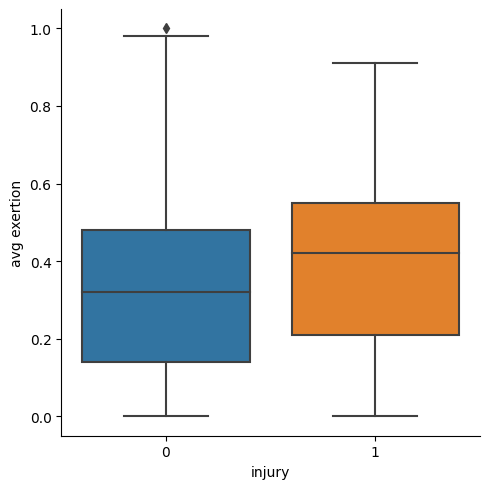

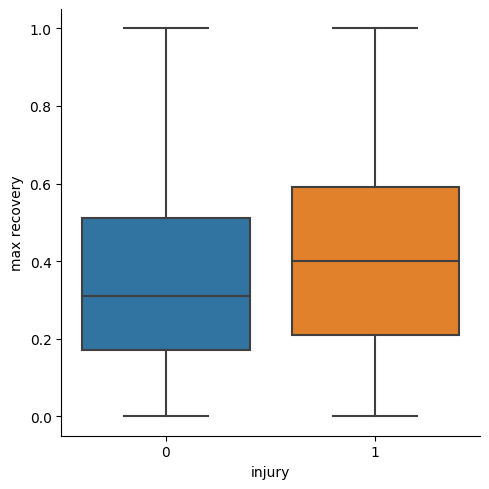

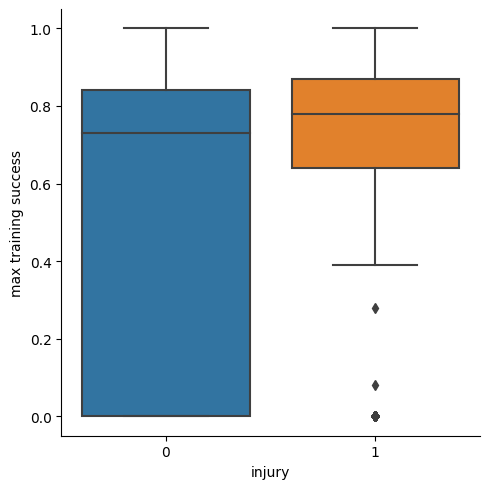

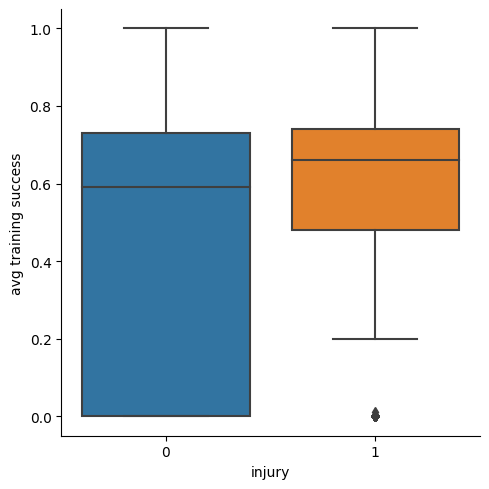

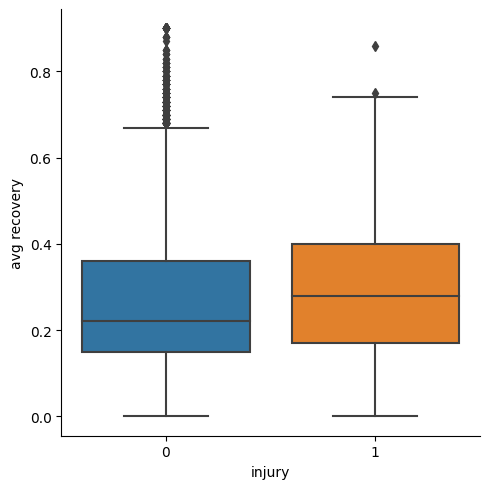

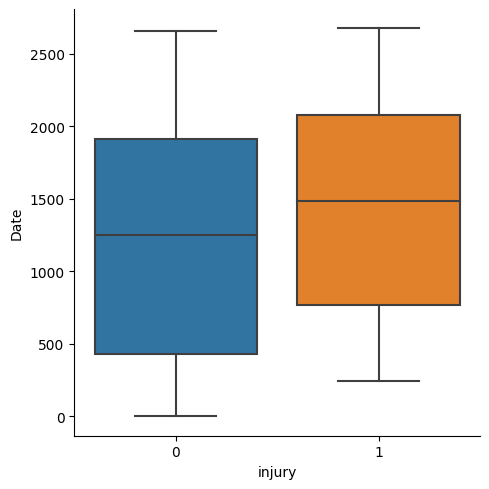

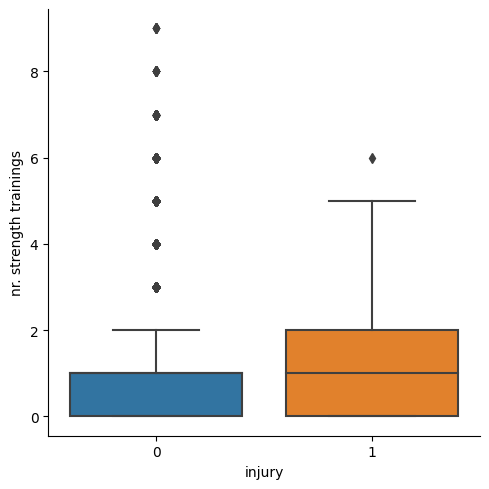

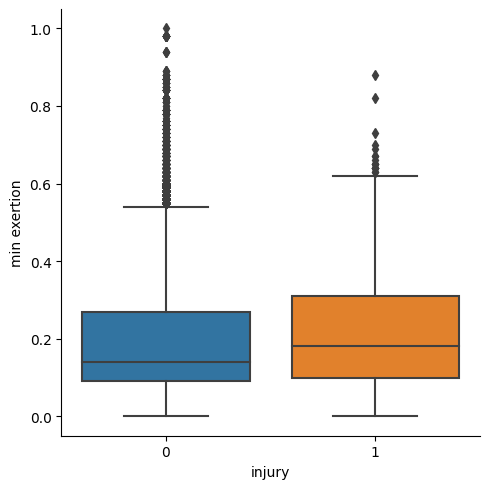

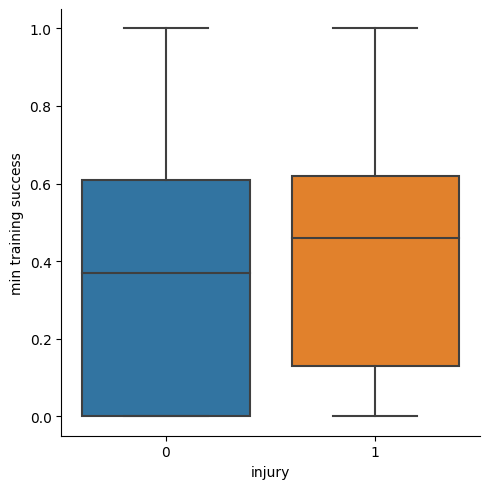

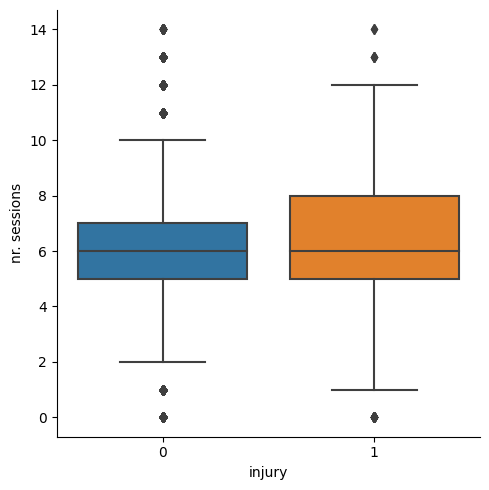

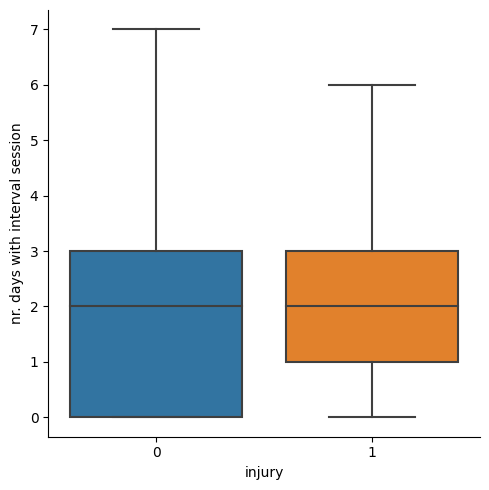

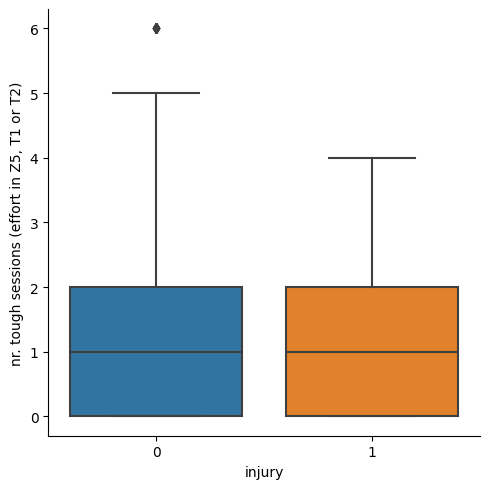

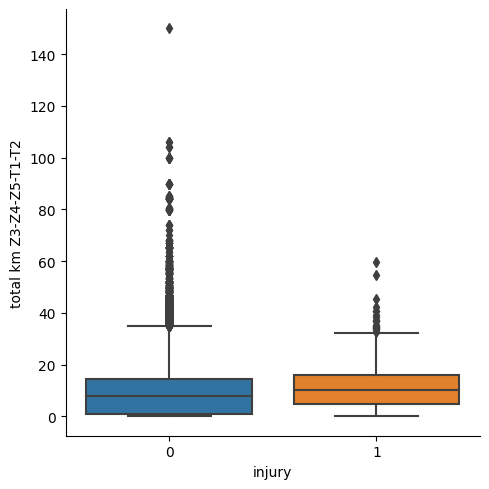

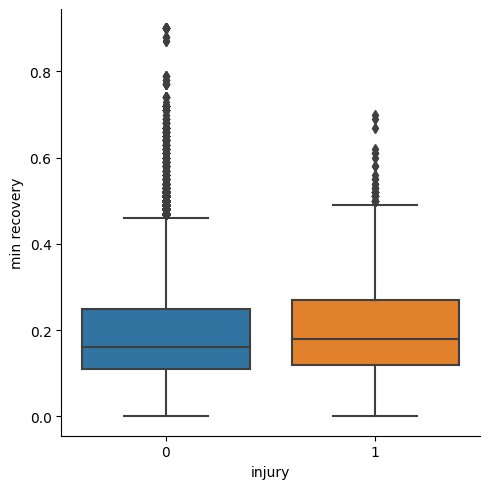

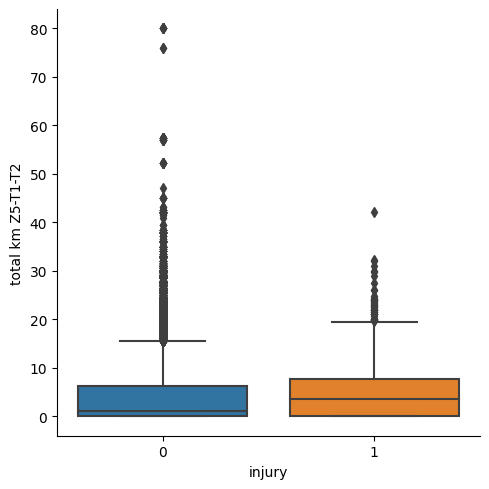

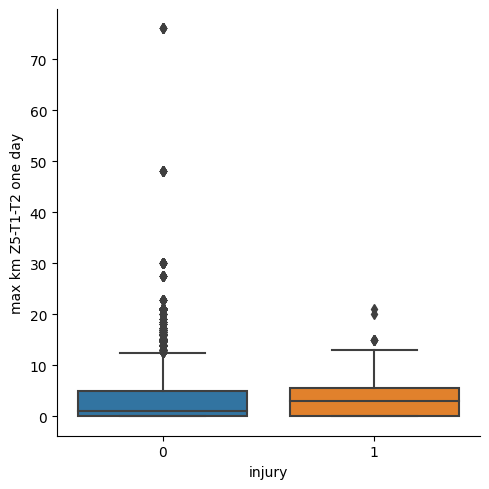

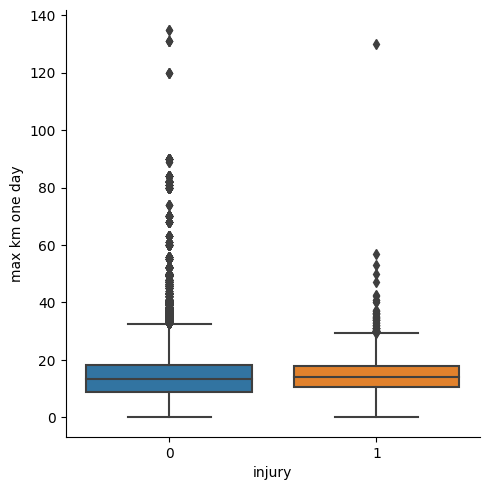

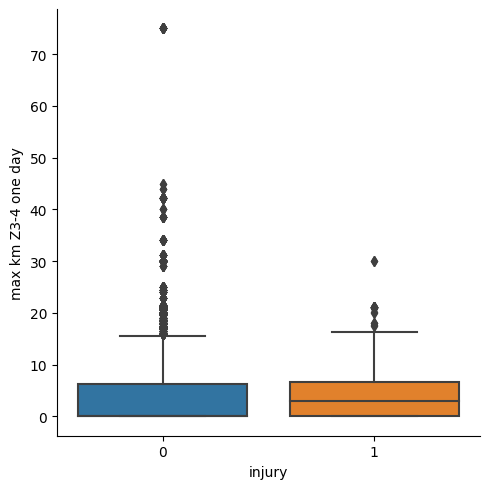

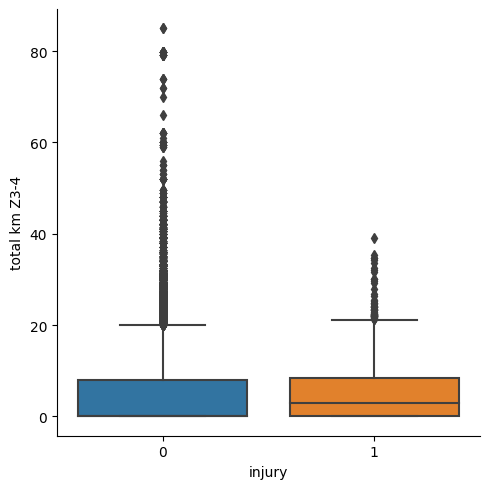

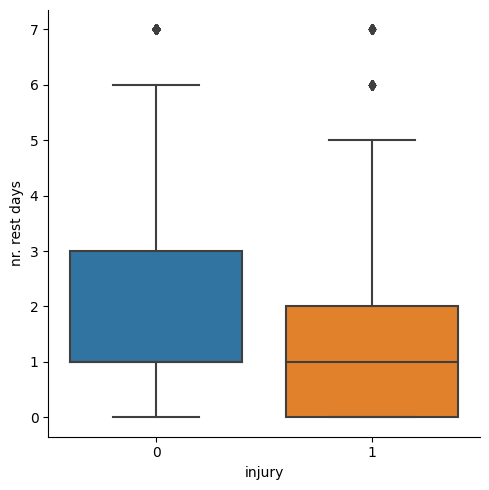

In [17]:
import seaborn as sns
df = df.dropna()
# plot "injury" against "max exertion"
for column in df_corr.column:
    if column != 'injury':
        sns.catplot(x="injury", y=column, kind="box", data=df)

0.664085135273824


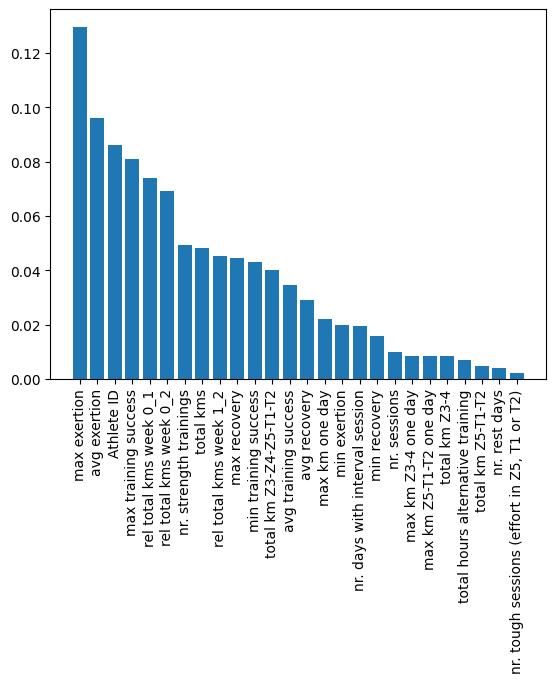

              precision    recall  f1-score   support

           0       0.67      0.63      0.65     63127
           1       0.66      0.70      0.67     63542

    accuracy                           0.66    126669
   macro avg       0.66      0.66      0.66    126669
weighted avg       0.66      0.66      0.66    126669



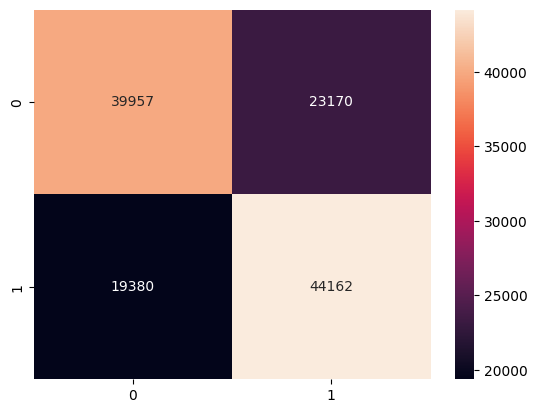

In [18]:
# build model to predict injury with random forst classifier



# Assuming df is your original DataFrame
# X features drop injury and date, y target variable
x = df.drop(['injury', 'Date'], axis=1)
y = df["injury"]

over_sampler = RandomOverSampler(sampling_strategy=1)  # Adjust the sampling_strategy as needed
# Create a pipeline with oversampling and undersampling
pipeline = make_pipeline( over_sampler)

# Fit and transform the data

X_resampled, y_resampled = pipeline.fit_resample(x, y)


# Create a new balanced DataFrame
balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=x.columns), pd.Series(y_resampled, name="injury")], axis=1)

# Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(balanced_df.drop("injury", axis=1), balanced_df["injury"], test_size=0.5, random_state=42)

# build the model

model = RandomForestClassifier(n_estimators=100, max_depth=5)

# train the model

model.fit(X_train, y_train)

# predict the test data

y_pred = model.predict(X_test)

# check the accuracy

print(accuracy_score(y_test, y_pred))

# plot the feature importance

feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": model.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
plt.bar(feature_importance["feature"], feature_importance["importance"])
plt.xticks(rotation=90)
plt.show()

# import confusion matrix


conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')

print(classification_report(y_test, y_pred))



In [19]:
injuries = balanced_df['injury'].values.tolist()
print(injuries.count(1))
print(injuries.count(0))

126669
126669


use case 1: predicting injuries given a training schedule
use case 2: determine a good recovery rate per athlete 
use case 3: determine how deep somoene should go each training
use case 4: determine how many km somoene should do per week 
use case 5: determine ideal anorobic levels 

In [27]:
# print average of "max exertion" when injury happens and when it doesn't
print("max exertion", df[df['injury'] == 1]['max exertion'].mean())
print("total kms", df[df['injury'] == 1]['total kms'].mean())
print("nr. strength trainings", df[df['injury'] == 1]['nr. strength trainings'].mean())
print("nr. rest days", df[df['injury'] == 1]['nr. rest days'].mean())

max exertion 0.5882492753623189
total kms 50.24573913043478
nr. strength trainings 1.0371014492753623
